### Occupancy dataset with data of:
* "Temperature"
* "Humidity"
* "Light"
* "CO2"
* "HumidityRatio" 
* "Occupancy"

In [1]:
import pandas as pd 

def plot_with_plotly_express(dataframe, plot_type, x_col, y_col=None, graph_title=None):
        """
        Plots a basic graph with Plotly Express.

        Parameters
        ----------
        dataframe : dataset

        plot_type : string
                Graph type, which should be a valid type among the ones provided by px (plotly express)

        x_col: string
                column name on the x axis
        
        y_col: string
                column on the y axis

        graph_title: string
                title of the graph

        Returns
        -------
        fig : plotly figure 

        """
        try:
            import plotly.express as px

            basic_plot_cases = {'bar': px.bar(dataframe, x=x_col, y=y_col, title=graph_title) ,
                                'scatter': px.scatter(dataframe, x=x_col, y=y_col, title=graph_title),
                                'line': px.line(dataframe, x=x_col, y=y_col, title=graph_title),
                                'pie': px.pie(dataframe, names=x_col, title=graph_title),
                                'histogram': px.histogram(dataframe, x=x_col, title=graph_title)
                                }

            fig = basic_plot_cases[plot_type]
            return fig

        except Exception as exc:
            return exc


In [13]:
occupancy_ts = pd.read_csv('datatraining.csv')

In [41]:
#df = pd.concat(map(pd.read_csv, ['datatraining.csv', 'datatest.csv','datatest2.csv']))

In [14]:
len(occupancy_ts)

8143

In [15]:
occupancy_ts = occupancy_ts.iloc[:4000]

In [16]:
plot_with_plotly_express(occupancy_ts, 'line', x_col='date', y_col='Temperature', graph_title='Temperatures')

It seems to have no missing data neither evident outliers

In [17]:
ts = occupancy_ts[['date', 'Temperature']]
ts.set_index('date', inplace=True)
ts.head(5)

Temperature
date                            
2015-02-04 17:51:00        23.18
2015-02-04 17:51:59        23.15
2015-02-04 17:53:00        23.15
2015-02-04 17:54:00        23.15
2015-02-04 17:55:00        23.10

In [18]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity_DFULLER(timeseries, window_time=12*60):
    import matplotlib.pyplot as plt
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window_time).mean()  #windows = nÃºmero de los Ãºltimos meses escogidos  
    rolstd = timeseries.rolling(window=window_time).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC')   
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)

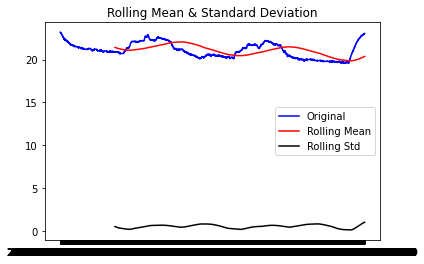

Results of Dickey-Fuller Test:
Test Statistic                   -1.656216
p-value                           0.453801
#Lags Used                       16.000000
Number of Observations Used    3983.000000
Critical Value (1%)              -3.431993
Critical Value (5%)              -2.862266
Critical Value (10%)             -2.567156
dtype: float64


In [19]:

test_stationarity_DFULLER(ts)

In [20]:
#ACF and PACF plots: Can we see any auto-correlations?
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts, nlags=12*60)
lag_pacf = pacf(ts, nlags=12*60, method='ols')

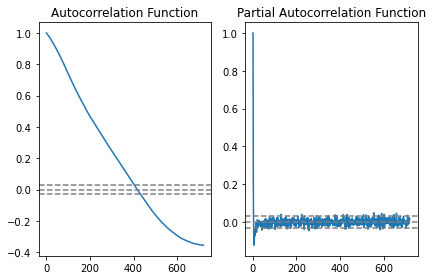

In [21]:
'''
A simpler measure of the scale of the autocorrelations is provided by the limits of Â±1.96/âT, which are the approximate 95% 
confidence bounds for the autocorrelations of a white-noise sequence (https://www.le.ac.uk/users/dsgp1/COURSES/TSERIES/8IDNTIFY.PDF)
'''
import matplotlib.pyplot as plt
import numpy as np 

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

* p: The number of lag observations included in the model, also called the lag order.
* d: The number of times that the raw observations are dierenced, also called the degree
of diferencing.
* q: The size of the moving average window, also called the order of moving average.


In [22]:
occupancy_ts['Temperature_diff'] = occupancy_ts['Temperature'].values - occupancy_ts['Temperature'].shift().values
plot_with_plotly_express(occupancy_ts, 'line', x_col='date', y_col='Temperature_diff', graph_title='Temperatures 1-order difference')

In [23]:
p = 0
d = 1
q = 600

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

def evaluate_arima_model(ts_values, arima_order):
    size = int(len(ts_values) * 0.80)
    train, test = ts_values[0:size], ts_values[size:len(ts_values)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        #prediction VS expected(test[t])
        predictions.append(yhat)
        #this step is based on 'Walk Forward Validation': 
        #  https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/ 
        # cada nuevo prediction va incluyendo en su train set un nuevo elemento de test set
        history.append(test[t])
        #print('expected test value: ', test[t], 'prediction: ', predictions[t])
        
    error = mean_squared_error(test, predictions)
    print('order: ', arima_order, ' error: ',error)
    return

In [24]:
evaluate_arima_model(ts.values, (p, d, q))

KeyboardInterrupt: 